# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель исследования**:
    
Построить модель, для определения стоимости, по возможности с наилучшими показателями:
- качество предсказания;
- скорость предсказания;
- время обучения.
    
**Ход исследования:** 
- загрузка данных;
- изучение данных:
    - заполнение пропущенных значений;
    - обработка дубликатов;
    - обработка аномалий;
    - удаление неинформативных признаков;
- подготовка выборок для обучения моделей;
- обучение различных моделей (с перебором гиперпараметров):
    - LightGBM;
    - как минимум одна - не бустинг;
- анализ моделей:
    - время обучения;
    - время предсказания;
    - качество моделей;
- выбор наилучшей модели по критериям Заказчика;
- проверка её качества на тестовой выборке.

**Импорт библиотек**

In [1]:
import os #импорт библиотеки os (для проверки существования пути к файлу)
from collections import Counter #импорт модуля Counter (поиск самого часто встречающегося значения в столбце)
import random #импорт функции рандом для заполнения пропусков случайными значениями пропорционально признакам

import pandas as pd #импорт библиотеки pandas (работа с таблицами)
import numpy as np
import matplotlib.pyplot as plt #импорт библиотеки matplotlib (графика)

from sklearn.model_selection import train_test_split #импорт инструмента для разделения выборок
from sklearn.preprocessing import StandardScaler #импорт инструмента масштабирования
from sklearn.preprocessing import OneHotEncoder #импорт инструмента преобразования категориальных признаков
from sklearn.preprocessing import OrdinalEncoder #импорт инструмента преобразования категориальных признаков для моделей случайного леса
from sklearn.ensemble import RandomForestRegressor #импорт модели случайного леса
from sklearn.linear_model import LinearRegression #импорт модели линейной регрессии
from sklearn.metrics import mean_squared_error #импорт метрики RMSE
from sklearn.model_selection import cross_val_score, GridSearchCV #импорт инструмента для перебора гиперпараметров с кросс-валидацией
from sklearn.metrics import make_scorer #импорт инструмента для создания своей метрики (RMSE)
from lightgbm import LGBMRegressor #импорт инструмента градиентного бустинга

import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

**Загрузка данных**

In [2]:
#путь для ревью
path1='/datasets/autos.csv'

#путь для работы
path2='autos.csv'

#выбор пути если он существует методом os
if os.path.exists(path1):
    #загрузка датасета методом pandas.read_csv
    df=pd.read_csv(path1)
elif os.path.exists(path2):
    df=pd.read_csv(path2)
else:
    print('Path does not exist')

**Изучение данных**

Рассмотрим импортированный датасет различными методами

In [3]:
#вывод информации о датасете методом info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Отсюда видно, что датасет содержит 354369 строк, однако в некоторых столбцах присутствуют пропуски. Выведем список таких столбцов:

In [4]:
#вывод списка с названиями колонок с пропусками
df_isna_cols=list(df.loc[:,df.isna().mean()!=0].columns)
df_isna_cols

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

Посмотрим на относительное число пропусков:

In [5]:
#подсчёт относительного числа пропусков в % в колонках с пропусками
pd.DataFrame({'Пропуски, %':df[df_isna_cols].isna().mean()*100}).style.background_gradient('coolwarm')

,"Пропуски, %"
VehicleType,10.579368
Gearbox,5.596709
Model,5.560588
FuelType,9.282697
Repaired,20.079070


Как видно, пропуски присутствуют в 5 столбцах из 15, при этом их число значительно: от 5% до 21% для разных столбцов. Максимальное значение - почти 21% - в столбце с информацией о нахождении машины в ремонте.

In [6]:
#вывод информации о столбцах с числовыми данными методом describe()
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Отсюда видно следующее:
    
    В датасете у всех автомобилей нет фотографий
    Цена: стоит иметь в виду, что среднее и медиана значительно отличаются, а также присутствуют нулевые значения
    В некоторых столбцах существуют выбросы: 
        год регистрации - минимальное значение - 1000, максимальное - 9999
        мощность, л.с. - минимальное значение - 0, максимальное - 20000
        
        

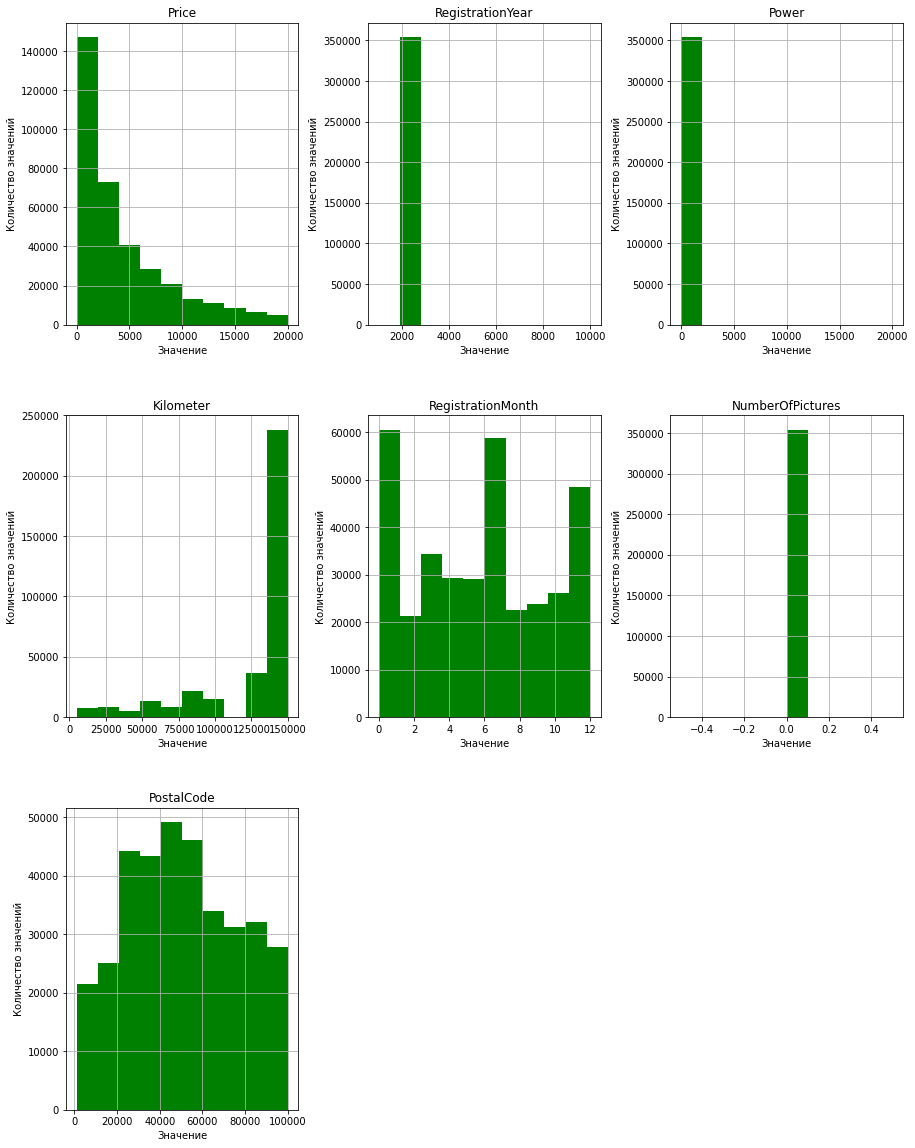

In [7]:
#вывод гистограмм распределений значений по количественным столбцам
hist=df.hist(figsize=(15,20),color='green')    
for ax in hist.flatten():
    ax.set_xlabel('Значение'),
    ax.set_ylabel('Количество значений')
plt.show()    

Для гистограмм по столбцам RegistrationYear, Power стандартным методом гистограмма малопоказательна. По данным столбцам построим распредления отдельно.

По гистограммам остальных столбцов в первом приближении заметно следующее:
- Цена: большинство автомобилей принадлежат низкому бюджетному классу, затем происходит убыль количества машин обратнопропорционально их стоимости: чем дороже автомобиль - тем реже встречается;
- Километраж: наибольшее количество машин продаются с пробегом 150000 км;
- Месяц регистрации: появляется интересная корреляция с месяцем покупки с пиками регистраций в январе, в июне и в декабре. Тогда как в остальное время года значения отличаются незначительно;
- Почтовый индекс владельца анкеты: в целом данный столбец непоказателен в части гистограммы, тк индексы имеют случайное распределение скорее по географическому распределнию.

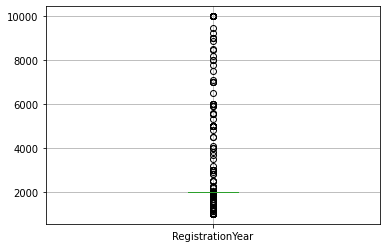

In [8]:
#построение диаграмы размаха для столбца с годом регистрации
df.boxplot('RegistrationYear');    

Очевидно, в данном столбце присутствуют выбросы: история автомобилестроения начинается в 1880-е года, а максимальная верхняя палка - это наибольший год занесения в базу (2016). На следующе этапе предобработки данных будем учитывать.

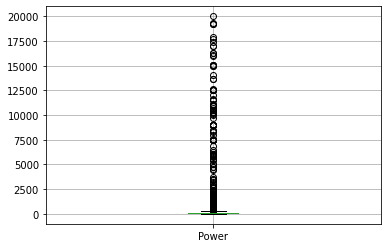

In [9]:
#построение диаграмы размаха для столбца с годом регистрации
df.boxplot('Power');    

В данном столбце тоже что-то не так: для большинства автомобилей в свободной продаже максимальное значение мощности в лошадиных силах не больше 1000 лс, тогда как мы видим множество значений и выше данного порога. Отметим это также на будущее для этапа предобработки данных.

**Вывод по разделу Исследование данных**

- в датасете присутствуют пропуски в столбцах: VehicleType, Gearbox, Model, FuelType, Repaired;
- в некоторых столбцах присутствуют выбросы: RegistrationYear, Power
- по гистограммам остальных столбцов в первом приближении заметно следующее:
    - Цена: большинство автомобилей принадлежат низкому бюджетному классу, затем происходит убыль количества машин обратнопропорционально их стоимости: чем дороже автомобиль - тем реже встречается. Также стоит отметить, что есть строки с нулевыми ценами, что необходимо иметь в виду при предобработке данных;
    - Километраж: наибольшее количество машин продаются с пробегом 150000 км;
    - Месяц регистрации: появляется интересная корреляция с месяцем покупки с пиками регистраций в январе, в июне и в декабре. Тогда как в остальное время года значения отличаются незначительно;
- в датасете присутствуют неинформативные признаки для предсказания стоимости автомобиля:
    - DateCrawled — дата скачивания анкеты из базы;
    - DateCreated — дата создания анкеты;
    - NumberOfPictures — количество фотографий автомобиля (у всех автомобилей фотографии остуствуют);
    - PostalCode — почтовый индекс владельца анкеты (пользователя);
    - LastSeen — дата последней активности пользователя.

**Предобработка данных**

Обработаем пропущенные значения в столбцах VehicleType, Gearbox, Model, FuelType, Repaired

**Обработка пропущенных значений столбца VehicleType (тип автомобильного кузова).**

Относительное число пропусков - 10,7%. 

Возможная причина появления пропусков: незаполненные данные пользователями и/или техническая ошибка.

Изучим данные по столбцу пристальнее.

In [10]:
#вывод уникальных значений столбца
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [11]:
#вывод первых строк всего датасета
df.head(50)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Из выведенных данных можно составить первое предложение для заполнения пропусков:

Для некоторых незаполненных типов VehicleType есть заполненные значения по столбцу Model. И для таких моделей в других строках есть заполненные типы автомобиля. Для начала можно взять и заполнить пропуски соответствующих моделей.

Попробуем посмотреть на примере модели polo:

In [12]:
#вывод уникальных значений столбца VehicleType для модели polo:
df.loc[df['Model']=='polo',:]['VehicleType'].unique()

array([nan, 'small', 'sedan', 'wagon', 'coupe', 'convertible', 'bus',
       'other', 'suv'], dtype=object)

Занятно, что для одной и той же модели существует различное заполнение информации о типе автомобиля. Странно только, что типы разнятся: от small (видимо это хэтчбеки) и sedan (седан), что вполне логично для общепринятого понятия для корпусов volkswagen polo, до bus (автобус) и suv ("паркетник" или городской внедорожник).

Посмотрим на распределение количества типов автомобиля для модели Polo:

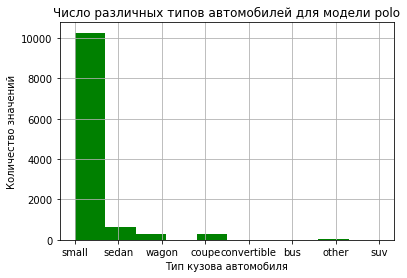

In [13]:
#вывод гистограммы распределения значений столбца VehicleType для модели polo
df.loc[df['Model']=='polo']['VehicleType'].hist(color='green')
plt.title('Число различных типов автомобилей для модели polo')
plt.xlabel('Тип кузова автомобиля')
plt.ylabel('Количество значений')
plt.show()    

Отсюда видно, что для данной модели (polo) примущественый тип авто - это small. Тогда есть смысл заполнить пропуски именно этим значением. Для дальнейшего использования достанем функцию Counter:

In [14]:
#вывод наиболее часто встречающегося значения VehicleType для модели polo
model_polo_max=Counter(df.loc[df['Model']=='polo']['VehicleType']).most_common(1)[0][0]
model_polo_max

'small'

In [15]:
#вывод информации о числе пропусков по для модели polo
len(df.loc[(df['Model']=='polo')&(df['VehicleType'].isna())])

1600

In [16]:
#заполнение пропусков столбца VehicleType для модели polo наиболее частым типом (small)
df.loc[(df['Model']=='polo')&(df['VehicleType'].isna()),'VehicleType']=model_polo_max

In [17]:
#вывод информации о числе пропусков по для модели polo
len(df.loc[(df['Model']=='polo')&(df['VehicleType'].isna())])

0

Таким образом мы заполнили пропуски для модели polo. Однако пропуски могут быть и для других моделей. Проверим эти модели:

In [18]:
#вывод моделей, имеющих пропуски по столбцу VehicleType
df[df['VehicleType'].isna()]['Model'].unique()

array(['golf', 'meriva', 'c4', 'clio', 'kangoo', 'corsa', 'punto',
       'other', 'astra', '5er', 'ka', 'insignia', 'civic', '3er', '100',
       'sportage', 'fabia', 'twingo', 'almera', 'zafira', 'caddy', nan,
       'i_reihe', 'fiesta', 'espace', 'jazz', 'a_klasse', 'transporter',
       'seicento', 'modus', 'c1', 'fox', 'c_max', 'ibiza', '2_reihe',
       '3_reihe', 'e_klasse', '500', 'cooper', '1er', 'galaxy', 'a3',
       'qashqai', 'lanos', 'megane', 'passat', 'scenic', 'b_klasse',
       'leon', 'vectra', 'c_klasse', '6_reihe', 'touran', 'transit',
       'cr_reihe', 'focus', 'carnival', 'fusion', 'fortwo', 'cordoba',
       'sprinter', 'mondeo', 'sharan', 'v70', 'c_reihe', 'rio', 'kaefer',
       'a6', 'ducato', 'calibra', 'a4', 'clk', 'ptcruiser', '4_reihe',
       's_klasse', 'arosa', 'matiz', 'beetle', 'stilo', 'v40', 'berlingo',
       'signum', 'primera', 'c2', 'tt', 'freelander', 'yaris', 'picanto',
       'tigra', 'samara', 'scirocco', '601', 'agila', 'combo', 'swift',


Так как моделей с пропусками по VehicleType много, то есть смысл пройти по моделям циклом и заполнить их аналогично.

In [19]:
#заполняем пропуски аналогично
#во избежание ошибки для model=nan указываем df[df['Model'].notna()
for model in list(df[df['Model'].notna()]['Model'].unique()):
    model_max=Counter(df.loc[df['Model']==model]['VehicleType']).most_common(1)[0][0]
    #заполнение пропусков столбца VehicleType для модели наиболее частым типом
    df.loc[(df['Model']==model)&(df['VehicleType'].isna()),'VehicleType']=model_max

Для всех моделей VehicleType должен был заполниться наиболее популярным VehiceType за исключением тех, где есть пропуск в столбце модели. Проверим это:

In [20]:
#вывод моделей, имеющих пропуски по столбцу VehicleType
df[df['VehicleType'].isna()]['Model'].unique()

array([nan, 'samara'], dtype=object)

Получается, что помимо пропусков по модели, есть ещё проблема для модели samara. Рассмотрим внимательнее:

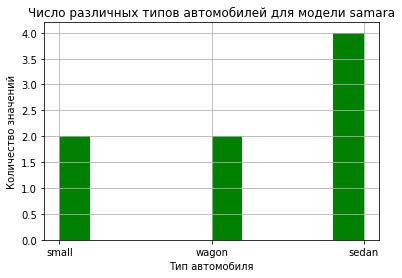

In [21]:
#вывод гистограммы распределения значений столбца VegicleType для модели samara
df.loc[df['Model']=='samara']['VehicleType'].hist(color='green')
plt.title('Число различных типов автомобилей для модели samara')
plt.xlabel('Тип автомобиля')
plt.ylabel('Количество значений')
plt.show()    

Как будто всё хорошо, проверим подсчёт самого частовстречающегося типа:

In [22]:
#вывод наиболее часто встречающегося значения VehicleType для модели samara
Counter(df.loc[df['Model']=='samara']['VehicleType']).most_common(1)[0][0]

nan

Вот и проблема: наиболее часто встречающийся тип автомобиля из всех - это пропуск. Заполним превентивно значением sedan (как наибольшее кроме пропусков)

In [23]:
#заполнение пропусков по столбцу VehicleType для модели samara
df.loc[(df['Model']=='samara')&(df['VehicleType'].isna()),'VehicleType']='sedan'

In [24]:
#вывод моделей, имеющих пропуски по столбцу VehicleType
df[df['VehicleType'].isna()]['Model'].unique()

array([nan], dtype=object)

Итак, пропуски по столбцу VehicleType остались только для тех строк, где и Model также пропуск. Посмотрим на число этих машин:

In [25]:
#проверка числа пропусков
len(df[df['VehicleType'].isna()])

6828

Оставшиеся пропуски заполним типом автомобиля other, другой.

In [26]:
#заполнение пропусков по столбцу VehicleType для модели samara
df.loc[df['VehicleType'].isna(),'VehicleType']='other'

In [27]:
#проверка числа пропусков
len(df[df['VehicleType'].isna()])

0

**Обработка пропущенных значений столбца Gearbox (тип коробки передач).**

Относительное число пропусков - 6%. 

Возможная причина появления пропусков: незаполненные данные пользователями и/или техническая ошибка.

Изучим данные по столбцу пристальнее.

In [28]:
#вывод уникальных значений столбца
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

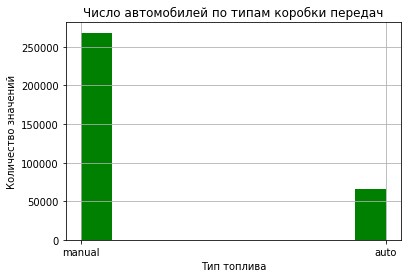

In [29]:
#вывод гистограммы распределения значений столбца Gearbox
df['Gearbox'].hist(color='green')
plt.title('Число автомобилей по типам коробки передач')
plt.xlabel('Тип топлива')
plt.ylabel('Количество значений')
plt.show()  

In [30]:
#доли различных типов коробок
print('Механическая коробка:',round(len(df[df['Gearbox']=='manual'])*100/len(df['Gearbox']),2),'%')
print('Автоматическая коробка:',round(len(df[df['Gearbox']=='auto'])*100/len(df['Gearbox']),2),'%')

Механическая коробка: 75.7 %
Автоматическая коробка: 18.71 %


Из выведенных данных можно составить следующее предложение: тк машина может быть только либо с механической коробкой передач либо только с автоматической, то есть смысл задать пропуски. При этом, с одной стороны, тк механики больше, то можно было бы заполнить механической коробко, но автоматическая тоже имеет свой вес: почти 19%. Поэтому заполним пропуски пропорционально содержанию данных по коробках случайным методом, но в пропорции 75,7:18,71.

In [31]:
#заполнение пропусков пропорционально содержащимся в столбцах категориям случайными категориями
df['Gearbox']=df['Gearbox'].fillna(pd.Series(
    random.choices(['manual','auto'],weights=df['Gearbox'].value_counts(normalize=True),k=len(df['Gearbox'].isna()))))

In [32]:
#проверка заполненных пропусков
len(df[df['Gearbox'].isna()])

0

**Обработка пропущенных значений столбца Model (модель автомобиля).**

Относительное число пропусков - 5,6%. 

Возможная причина появления пропусков: незаполненные данные пользователями и/или техническая ошибка.

Очевидного способа заполнить пропуск нет: на стоимость автомобиля его модель является наиболее важным критерием, и даже если заполнять пропуски самой популярной моделью марки, то велика ероятность наплодить ошибок на будущее (не как с типом кузова, так как это не такой важный фактор, да и есть ощущение, что некоторые модели имеют единственный наиболее популярный тип кузова). 

Однако, есть смысл заменить пропуски на значение-заглушку, тогда, возможно, модель обучения будет лучше предсказывать стоимость автомобилей для тех клиентов, кто забыл ввести (или не знает) модель автомобиля.

Заполним пропуски значением заглушки not_indicated (не указано).

In [33]:
#проверка числа пропусков
len(df[df['Model'].isna()])

19705

In [34]:
#заполнение пропусков по столбцу 
df.loc[df['Model'].isna(),'Model']='not_indicated'

In [35]:
#проверка числа пропусков
len(df[df['Model'].isna()])

0

**Обработка пропущенных значений столбца FuelType (тип топлива).**

Относительное число пропусков - 9,3%. 

Возможная причина появления пропусков: незаполненные данные пользователями и/или техническая ошибка.

Изучим данные по столбцу пристальнее.

In [36]:
#вывод уникальных значений столбца
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

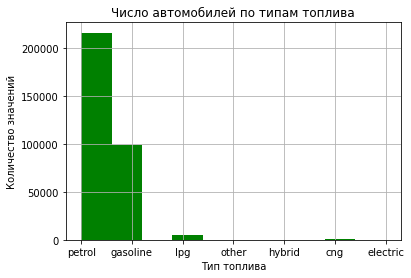

In [37]:
#вывод гистограммы распределения значений столбца
df['FuelType'].hist(color='green')
plt.title('Число автомобилей по типам топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Количество значений')
plt.show()  

Интересное наблюдение: в датасете представлены в основном только автомобили с бензиновыми двигателями (причём бензин имеет два названия: petrol и gasoline, видимо в зависимости от страны использования авто). Дизельные не указаны вовсе, а остальные: lpg,other,hybrid,cng,electric занимают совсем незначительную долю.

Есть смысл заменить пропуски значением для бензиного двигателя. А также есть смысл заменить название gasoline на petrol для унификации, ведь по сути это одно и то же.

In [38]:
#проверка числа пропусков
len(df[df['FuelType'].isna()])

32895

In [39]:
#заполнение пропусков по столбцу
df.loc[df['FuelType'].isna(),'FuelType']='petrol'

In [40]:
#проверка числа пропусков
len(df[df['FuelType'].isna()])

0

In [41]:
#замена значений gasoline на petrol
df.loc[df['FuelType']=='gasoline','FuelType']='petrol'

In [42]:
#проверка замены gasoline на petrol
df['FuelType'].unique()

array(['petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

**Обработка пропущенных значений столбца Repaired (была машина в ремонте или нет).**

Относительное число пропусков - 20%. 

Возможная причина появления пропусков: незаполненные данные пользователями и/или техническая ошибка.

По данному столбцу есть следующие рассуждения:

Этот признак значимый: очевидно, что на стоимость автомобиля очень сильно влияет был ли он в ремонте или нет.

Этот признак может иметь не прямую корреляцию с заполненными данными,а именно: для тех машин, где указано, что были в ремонте - они реально были в ремонте. Для тех машин, где указано, что не были - возможно, они всё-таки были в ремонте. А для тех, для которых не указано - скорее всего они были в ремонте, но это не указано специально чтобы завысить цену. 

В общем много от чего зависит этот столбец. Попробуем заполнить случайным значением пропорционально заполненным данным, как для типа коробки передач. А если далее возникнут неудовлетворительные показания модели предсказаний, то можно будет вернуться к этому вопросу.

In [43]:
#проверка числа пропусков
len(df[df['Repaired'].isna()])

71154

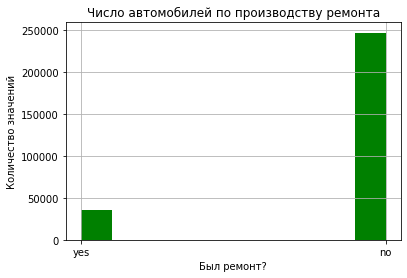

In [44]:
#вывод гистограммы распределения значений столбца
df['Repaired'].hist(color='green')
plt.title('Число автомобилей по производству ремонта')
plt.xlabel('Был ремонт?')
plt.ylabel('Количество значений')
plt.show()  

In [45]:
#доли различных типов коробок
print('Был ремонт:',round(len(df[df['Repaired']=='yes'])*100/len(df['Repaired']),2),'%')
print('Не было ремонта:',round(len(df[df['Repaired']=='no'])*100/len(df['Repaired']),2),'%')

Был ремонт: 10.17 %
Не было ремонта: 69.75 %


In [46]:
df.head(100)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,not_indicated,125000,5,petrol,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2016-03-25 18:44:10,3850,sedan,2003,manual,131,passat,150000,5,petrol,volkswagen,no,2016-03-25 00:00:00,0,30459,2016-04-07 00:16:18
96,2016-03-26 15:38:12,6450,bus,2008,manual,84,transporter,150000,12,petrol,volkswagen,no,2016-03-26 00:00:00,0,44623,2016-04-06 03:17:37
97,2016-04-01 12:45:41,1700,small,1999,auto,102,a_klasse,125000,11,petrol,mercedes_benz,no,2016-04-01 00:00:00,0,12305,2016-04-01 12:45:41
98,2016-03-11 19:00:25,4290,bus,2008,manual,0,combo,150000,2,petrol,opel,no,2016-03-11 00:00:00,0,23568,2016-04-05 22:45:32


In [47]:
#заполнение пропусков пропорционально содержащимся в столбцах категориям случайными категориями
df['Repaired']=df['Repaired'].fillna(pd.Series(
    random.choices(['no','yes'],weights=df['Repaired'].value_counts(normalize=True),k=len(df['Repaired'].isna()))))

In [48]:
#проверка заполненных пропусков
len(df[df['Repaired'].isna()])

0

In [49]:
#доли различных типов коробок
print('Был ремонт:',round(len(df[df['Repaired']=='yes'])*100/len(df['Repaired']),2),'%')
print('Не было ремонта:',round(len(df[df['Repaired']=='no'])*100/len(df['Repaired']),2),'%')

Был ремонт: 12.76 %
Не было ремонта: 87.24 %


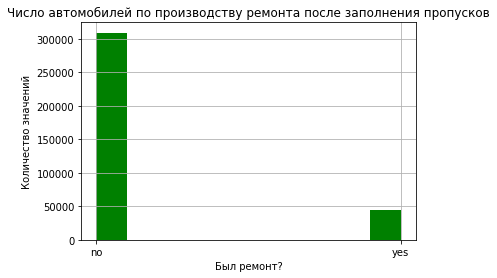

In [50]:
#вывод гистограммы распределения значений столбца
df['Repaired'].hist(color='green')
plt.title('Число автомобилей по производству ремонта после заполнения пропусков')
plt.xlabel('Был ремонт?')
plt.ylabel('Количество значений')
plt.show()  

**Обработка аномальных значений**

В некоторых столбцах встречаются выбросы, а именно: RegistrationYear (год регистрации) и Power (мощность, лс). Посмотрим что можно сделать в этих случаях.

**Обработка выбросов в столбце RegistrationYear**

In [51]:
df['RegistrationYear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

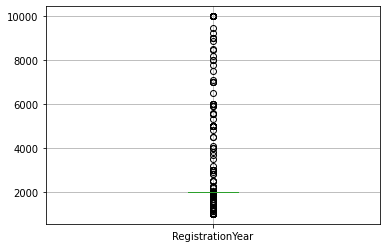

In [52]:
df.boxplot('RegistrationYear');

Первым шагом можно удалить все строки, в которых год регистрации меньше, чем год получения патента на первый автомобиль - 1886. Посмотрим, сколько таких автомобилей:

In [53]:
#нахождение числа автомобилей с годом регистрации меньше 1886
df.loc[df['RegistrationYear']<1886,'RegistrationYear'].count()

66

66 строк - очень малое число относительно общей длины. Можно смело удалить.

In [54]:
#сохранение автомобилей с годом регистрации после 1886
df=df.loc[df['RegistrationYear']>=1886,]

Проверим нижнюю границу по маркам. Возьмём какой-нибудь средний год, например, 1950:

In [55]:
#нахождение марок автомобилей для года выпуска раньше 1950
df.loc[df['RegistrationYear']<1950,]['Brand'].unique()

array(['ford', 'volkswagen', 'sonstige_autos', 'opel', 'audi',
       'alfa_romeo', 'chrysler', 'fiat', 'bmw', 'hyundai', 'trabant',
       'mercedes_benz', 'jeep', 'renault', 'citroen', 'peugeot',
       'chevrolet', 'mitsubishi', 'subaru', 'toyota'], dtype=object)

По маркам можно сказать следующее: hyundai создана в 1967 году. Можно удалить строки с условием: hyundai и не старше 1967. В остальном явных выбросов не наблюдается.

In [56]:
#удаление строк, индекс которых соответствует строкам, у которых hyundai раньше 1967
df=df.drop(labels=df.loc[(df['RegistrationYear']<1967)&(df['Brand']=='hyundai')].index,axis=0)

Теперь рассмотрим верхние границы строк с датам выпуска автомобилей. Сначала выясним максимальный год для даты создания анкеты автомобиля в базе данных:

In [57]:
#определение максимального значения года в датах занесения в базу данных
pd.to_datetime(df['DateCreated']).dt.to_period("Y").unique().max()

Period('2016', 'A-DEC')

Отсюда видно, что последний год занесения в базу данных - 2016, тогда как в столбце с годом регистрации автомобиля присутствуют бОльшие значения, проверим их количество:

In [58]:
print('Абсолютное количество:',len(df.loc[df['RegistrationYear']>2016,]['RegistrationYear']))
print('Относительное количество,%',round(100*len(df.loc[df['RegistrationYear']>2016,]['RegistrationYear'])/len(df),2))

Абсолютное количество: 14530
Относительное количество,% 4.1


Количество строк довольно значительно в абсолютных значениях. Посмотрим на уникальные значения дат регистрации автомобилей:

In [59]:
#вывод уникальных значений лет регистрации автомобилей
df.loc[df['RegistrationYear']>2016,]['RegistrationYear'].unique()

array([2018, 2017, 5000, 9999, 3200, 8888, 2200, 4100, 3000, 2066, 2019,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 4000, 8500, 3700, 3800,
       4800, 7000, 6500, 2290, 2500, 9450, 2800, 5555, 5600, 2222, 9996,
       8455, 4500, 7800, 9229, 7100, 8200, 7500, 3500])

Последняя реалистичная цифра - 2019. Проверим число строк со значениями, бОльшими 2019:

In [60]:
#вывод числа автомобилей с датой регистрации после 2019 года
df.loc[df['RegistrationYear']>2019,]['RegistrationYear'].count()

105

Это число строк уже больше похоже на аномалии. Предположим, что проблема не с годом регистрации автомобиля, а с датами создания анкеты и скачивания её из базы данных, а автомобили с 2017, 2018, 2019 годами регистрации реальны. Удалим строки с датами регистрации больше 2019:

In [61]:
#сохранение автомобилей с годом регистрации менее 2019 включительно
df=df.loc[df['RegistrationYear']<=2019,]

**Обработка выбросов в столбце Power**

In [62]:
df['Power'].describe()

count    354196.000000
mean        110.078863
std         189.537120
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

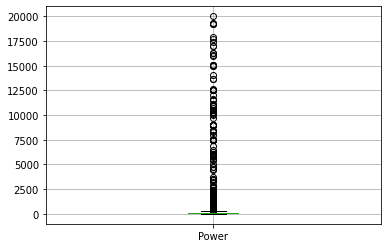

In [63]:
df.boxplot('Power');

Отсюда видно, что есть преобладающее число выбросов - по верхним значениям, но также присутствуют и нулевые значения. Начнём с нулевых значений:

In [64]:
#вывод числа строк с нулевой мощностью
len(df[df['Power']==0])

40096

Как оказалось, нулевых значений в данном столбце очень много: 40096. Есть смысл заполнить их средними значениями по модели.

In [65]:
#заполняем нулевые значения согласно средней по модели
#во избежание ошибки для model=nan указываем df[df['Model'].notna()
for model in list(df[df['Model'].notna()]['Model'].unique()):
    model_power_mean=df.loc[df['Model']==model]['Power'].mean()
    #заполнение нулевых значений столбца Power для модели средней мощностью
    df.loc[(df['Model']==model)&(df['Power']==0),'Power']=model_power_mean

In [66]:
#проверка заполнения пропусков
len(df[df['Power']==0])

2

Как оказалось, остались 2 пропуска. Проверим:

In [67]:
#вывод моделей с оставшимися нулевыми значениями
df[df['Power']==0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
234296,2016-03-30 11:39:08,3800,wagon,1978,manual,0.0,serie_1,30000,0,petrol,land_rover,no,2016-03-30 00:00:00,0,49824,2016-03-30 11:39:08
280216,2016-04-02 10:53:15,0,wagon,1970,manual,0.0,serie_1,100000,0,petrol,land_rover,no,2016-04-02 00:00:00,0,88634,2016-04-06 09:16:22


Видимо это редкие модели, у которых у обеих не указана мощность. Проверим:

In [68]:
#вывод модели land_rover serie_1
df[df['Model']=='serie_1']

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
234296,2016-03-30 11:39:08,3800,wagon,1978,manual,0.0,serie_1,30000,0,petrol,land_rover,no,2016-03-30 00:00:00,0,49824,2016-03-30 11:39:08
280216,2016-04-02 10:53:15,0,wagon,1970,manual,0.0,serie_1,100000,0,petrol,land_rover,no,2016-04-02 00:00:00,0,88634,2016-04-06 09:16:22


Действительно, это редкая модель. По смыслу заполнить эти по сути пропуски не находится возможности. Есть смысл удалить данные строки.

In [69]:
#удаление строк с нулевой мощностью
df=df[df['Power']!=0]

Теперь займёмся аномальными значениями по высокой стороне. В принципе, самый мощный автомобиль на сегодняшний день имеет мощность в 2000 л.с. Есть смысл удалить все строки со значениями выше.

In [70]:
#удаление строк с мощностью автомобилей выше 2000 л.с.
df=df[df['Power']<=2000]

**Вопрос с нулевыми значениями цен**

По сути, эти данные являются пропусками. Однако заполнять их синтетически может и не стоит, ведь нам придётся предсказывать цены, и для обучения лучше иметь реальные цифры в особенности для такого важного параметра как целевой параметр цены. Проверим число пропусков:

In [71]:
round(100*len(df[df['Price']==0])/len(df),2)

3.03

3% строк с неуказанными ценами. Есть смысл удалить их.

In [72]:
df=df[df['Price']!=0]

**Удаление неинформативных признаков**

В датасете присутствуют неинформативные признаки для предсказания стоимости автомобиля:

    - DateCrawled — дата скачивания анкеты из базы;
    - DateCreated — дата создания анкеты;
    - NumberOfPictures — количество фотографий автомобиля (у всех автомобилей фотографии остуствуют);
    - PostalCode — почтовый индекс владельца анкеты (пользователя);
    - LastSeen — дата последней активности пользователя.

Есть смысл удалить их.

In [73]:
df=df.drop(labels=['DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen'],axis=1)

In [74]:
df=df.reset_index()

## Обучение моделей

**Разделение выборок**

Разделим выборки для обучения моделей на обучающую, валидационную и тестовую в соотношении 60:40:20. Целевой признак - цена автомобиля.

In [75]:
#задание константы random state:
RS=12345

#разделение выборок
target=df['Price']
features=df.drop(['Price'],axis=1)
features_train,features_validtest,target_train,target_validtest=train_test_split(
    features,target,train_size=0.6,random_state=RS)

features_valid,features_test,target_valid,target_test=train_test_split(
    features_validtest,target_validtest,train_size=0.25,random_state=RS)

In [76]:
#сохраняем перечень численных признаков
numeric_columns=['RegistrationYear','Power','Kilometer','RegistrationMonth']

#обучение инструмента масштабирования
scaler=StandardScaler()
scaler.fit(features_train[numeric_columns])

#масштабирование численных признаков
features_train[numeric_columns]=scaler.transform(features_train[numeric_columns])
features_valid[numeric_columns]=scaler.transform(features_valid[numeric_columns])
features_test[numeric_columns]=scaler.transform(features_test[numeric_columns])

In [77]:
#сохраняем перечень категориальных переменных
categorical_columns=['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

#преобразование категориальных переменных
encoder=OneHotEncoder(drop='first', handle_unknown='error')

encoder.fit(features_train[categorical_columns])

features_train_encoded=pd.DataFrame(encoder.transform(features_train[categorical_columns]).toarray(),
                                   columns=encoder.get_feature_names(categorical_columns),
                                   index=features_train.index)
features_train=pd.concat((features_train[numeric_columns],features_train_encoded),axis=1)

features_valid_encoded=pd.DataFrame(encoder.transform(features_valid[categorical_columns]).toarray(),
                                   columns=encoder.get_feature_names(categorical_columns),
                                   index=features_valid.index)
features_valid=pd.concat((features_valid[numeric_columns],features_valid_encoded),axis=1)

features_test_encoded=pd.DataFrame(encoder.transform(features_test[categorical_columns]).toarray(),
                                   columns=encoder.get_feature_names(categorical_columns),
                                   index=features_test.index)
features_test = pd.concat((features_test[numeric_columns], features_test_encoded), axis=1)

In [78]:
#создание функции расчёта RMSE
def RMSE(target,predictions):
    return(mean_squared_error(target,predictions)**0.5)

#создание критерия оценки RMSE для моделей для подбра параметром методом GridSearchCV
new_scorer=make_scorer(RMSE,greater_is_better=False)

**Обучение модели линейной регрессии**

In [79]:
%%time
#Обучение модели линейной регрессии
model_0=LinearRegression()
model_0.fit(features_train,target_train)

CPU times: user 17.6 s, sys: 9.05 s, total: 26.6 s
Wall time: 26.6 s


LinearRegression()

In [80]:
%%time
#Предсказание модели линейной регрессии
predictions_0=model_0.predict(features_valid)

CPU times: user 84.3 ms, sys: 81.3 ms, total: 166 ms
Wall time: 179 ms


In [81]:
predictions_0

array([ 3532.8806314 ,  2005.97427017,  7674.62255112, ...,
       11063.0232329 ,   947.50168284,  3708.39634843])

In [82]:
target_valid

336187     2750
174855     2100
205594      950
231727     5500
202289     1990
          ...  
233343    10500
240416     1999
177343    15400
86643      1550
117489      900
Name: Price, Length: 34334, dtype: int64

In [83]:
#подсчёт метрики RMSE
model_0_RMSE=RMSE(target_valid,predictions_0)
model_0_RMSE

2972.7848747496746

Как видно, без перебора гиперпараметров, модель линейной регресии даёт результат RMSE, равный 2970. Время обучения = 58.9 с, время предсказания модели = 126 мс. 

Далее попробуем подобрать гиперпараметры методом GridSeacrhCV и посмотрим на новый результат RMSE.

In [84]:
%%time
parametres={'fit_intercept':[True,False], 'normalize':[True,False]}
model=LinearRegression()
best_model_0=GridSearchCV(model,parametres,cv=2,scoring=new_scorer)
best_model_0.fit(features_train,target_train)

print(best_model_0.best_params_)
print(abs(best_model_0.best_score_))

{'fit_intercept': True, 'normalize': False}
2954.3767826124804
CPU times: user 1min 21s, sys: 48.5 s, total: 2min 10s
Wall time: 2min 10s


In [85]:
%%time
#Предсказание модели линейной регрессии с наилучшими гиперпараметрами
predictions_best_0=best_model_0.predict(features_valid)

CPU times: user 39.9 ms, sys: 19.7 ms, total: 59.7 ms
Wall time: 20.5 ms


In [86]:
#подсчёт метрики RMSE
best_model_0_RMSE=RMSE(target_valid,predictions_best_0)
best_model_0_RMSE

2972.7848747496746

Как видно, с перебором гиперпараметров, наилучшая модель линейной регресии даёт результат RMSE, равный 2970. (Такой же, как и без перебора гиперпараметров). Время обучения с перебором гиперпараметров методом GridSearchCV = 5 минут 49 секунд, время предсказания модели = 31,7 мс. 

**Общий вывод по модели линейной регрессии:** 

Без перебора гиперпараметров:
    
    время обучения = 58.9 с, время предсказания = 126 мс, RMSE = 2971
    
С перебором гиперпараметров методом GridSearchCV:
    
    время обучения = 5 минут 49 секунд , время предсказания = 31.7 мс, RMSE = 2970
    
По условиям задачи, RMSE должна быть не более 2500. Таким образом, данная модель не подходит для решения задачи регрессии для настоящего датасета.

**Обучение модели случайного леса**

In [87]:
#разделение выборок
target=df['Price']
features=df.drop(['Price'],axis=1)
features_train,features_validtest,target_train,target_validtest=train_test_split(
    features,target,train_size=0.6,random_state=RS)

features_valid,features_test,target_valid,target_test=train_test_split(
    features_validtest,target_validtest,train_size=0.25,random_state=RS)

In [88]:
#сохраняем перечень численных признаков
numeric_columns=['RegistrationYear','Power','Kilometer','RegistrationMonth']

#обучение инструмента масштабирования
scaler=StandardScaler()
scaler.fit(features_train[numeric_columns])

#масштабирование численных признаков
features_train[numeric_columns]=scaler.transform(features_train[numeric_columns])
features_valid[numeric_columns]=scaler.transform(features_valid[numeric_columns])
features_test[numeric_columns]=scaler.transform(features_test[numeric_columns])

In [89]:
# порядковое кодирование для модели случайного леса
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
#сохраняем перечень категориальных переменных
categorical_columns=['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']
encoder.fit(features_train[categorical_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[categorical_columns] = encoder.transform(features_train_ord[categorical_columns])
features_valid_ord[categorical_columns] = encoder.transform(features_valid_ord[categorical_columns])
features_test_ord[categorical_columns] = encoder.transform(features_test_ord[categorical_columns])

In [90]:
%%time
#Обучение модели случайного леса
model_1=RandomForestRegressor(random_state=RS)
model_1.fit(features_train_ord,target_train)

CPU times: user 1min 41s, sys: 0 ns, total: 1min 41s
Wall time: 1min 41s


RandomForestRegressor(random_state=12345)

In [91]:
%%time
#Предсказание модели случайного леса
predictions_1=model_1.predict(features_valid_ord)

CPU times: user 2.1 s, sys: 0 ns, total: 2.1 s
Wall time: 2.11 s


In [92]:
#подсчёт метрики RMSE
model_1_RMSE=RMSE(target_valid,predictions_1)
model_1_RMSE

1751.6356474667266

Как видно, без перебора гиперпараметров, модель случайного леса даёт результат RMSE, равный 1717. Время обучения = 7 минут 18 секунд, время предсказания модели = 2,11 с. 

Результаты уже лучше, чем модель линейной регрессии.

Далее попробуем подобрать гиперпараметры методом GridSeacrhCV и посмотрим на новый результат RMSE.

In [93]:
%%time

parametres={'max_depth': range (11,13)}
model=RandomForestRegressor(random_state=RS)
best_model_1=GridSearchCV(model,parametres,cv=2,scoring=new_scorer)
best_model_1.fit(features_train_ord,target_train)

print(best_model_1.best_params_)
print(abs(best_model_1.best_score_))

{'max_depth': 12}
1882.2389064256795
CPU times: user 2min 46s, sys: 0 ns, total: 2min 46s
Wall time: 2min 47s


In [94]:
%%time
#Предсказание модели случайного леса с наилучшими гиперпараметрами
predictions_best_1=best_model_1.predict(features_valid_ord)

CPU times: user 429 ms, sys: 0 ns, total: 429 ms
Wall time: 436 ms


In [95]:
#подсчёт метрики RMSE
best_model_1_RMSE=RMSE(target_valid,predictions_best_1)
best_model_1_RMSE

1873.6908419207136

Как видно, c перебором гиперпараметров, наилучшая модель случайного леса даёт результат RMSE, равный 1891. Время обучения с перебором гиперпараметров методом GridSearchCV = 9 минут 43 секунды, время предсказания модели = 246 мс. 

**Общий вывод по модели случайного леса:** 

Без перебора гиперпараметров:
    
    время обучения = 1 минута 24 секунды , время предсказания = 1,75 с, RMSE = 1745
    
С перебором гиперпараметров методом GridSearchCV:
    
    время обучения = 2 минуты 20 секунд, время предсказания = 386 мс, RMSE = 1871
    
Данная модель также по требованию к качеству RMSE, а также можно использовать модель без перебора гиперпараметров, так как RMSE даже ухудшилась при более длительном переборе гиперпараметров. При этом, время обучения и время предсказания больше, чем для модели линейной регрессии, но с новым кодированием данных это уже сопоставимое время.

**Обучение модели градиентного бустинга lightgbm**

In [96]:
%%time
#Обучение модели градиентного бустинга
model_2=LGBMRegressor(random_state=RS)
model_2.fit(features_train_ord,target_train)

CPU times: user 6min 1s, sys: 1.04 s, total: 6min 2s
Wall time: 6min 6s


LGBMRegressor(random_state=12345)

In [97]:
%%time
#Предсказание модели градиентного бустинга
predictions_2=model_2.predict(features_valid_ord)

CPU times: user 337 ms, sys: 0 ns, total: 337 ms
Wall time: 319 ms


In [98]:
#подсчёт метрики RMSE
model_2_RMSE=RMSE(target_valid,predictions_2)
model_2_RMSE

1825.1914739862223

Как видно, без перебора гиперпараметров, модель градиентного бустинга даёт результат RMSE, равный 1808. Время обучения = 43,1 с, время предсказания модели = 483 мс. 

Результаты RMSE также удовлетворяют задаче, но немного хуже, чем в модели случайного леса. При этом время обучения сопоставимо с временем оубчения для линейной регрессии и на порядок быстрее случайного леса.

Далее попробуем подобрать гиперпараметры методом GridSeacrhCV и посмотрим на новый результат RMSE.

In [99]:
%%time

parametres={'max_depth': range (11,13)}
model=LGBMRegressor(random_state=RS)
best_model_2=GridSearchCV(model,parametres,cv=2,scoring=new_scorer)
best_model_2.fit(features_train_ord,target_train)

print(best_model_2.best_params_)
print(abs(best_model_2.best_score_))

{'max_depth': 11}
1811.374086389469
CPU times: user 4min 13s, sys: 1.01 s, total: 4min 14s
Wall time: 4min 17s


In [100]:
%%time
#Предсказание модели градиентного бустинга с наилучшими гиперпараметрами
predictions_best_2=best_model_2.predict(features_valid_ord)

CPU times: user 296 ms, sys: 2.23 ms, total: 298 ms
Wall time: 302 ms


In [101]:
#подсчёт метрики RMSE
best_model_2_RMSE=RMSE(target_valid,predictions_best_2)
best_model_2_RMSE

1828.2037633906727

Как видно, c перебором гиперпараметров, наилучшая модель градиентного бустинга даёт результат RMSE, равный 1883. Время обучения с перебором гиперпараметров методом GridSearchCV = 3 минуты 17 секунд, время предсказания модели = 372 мс. 

**Общий вывод по модели градиентного бустинга Lightgbm:** 

Скорректированный вывод по модели градиентного бустинга:
    
Без перебора гиперпараметров:
    
    время обучения = 2 минуты 10 секунд , время предсказания = 215 мс, RMSE = 1819
    
С перебором гиперпараметров методом GridSearchCV:
    
    время обучения = 46,8 секунд, время предсказания = 292 мс, RMSE = 1817
    
Данная модель проходит также по требованию к качеству RMSE, а также можно использовать модель без перебора гиперпараметров, так как RMSE значительно не изменилась. При этом стоит отметить, что при новом методе кодирования данных скорость обучения увеличилась очень значительно, в несколько раз.

## Анализ моделей

Лучше всего по метрике RMSE показала себя модель случайного леса без перебора гиперпараметров с кросс-валидацией методом GridSearchCV: 
    
    время обучения = 1 минута 24 секунды , время предсказания = 1,75 с, RMSE = 1745
    
На втором месте по качеству RMSE - бустинг (с перебором гиперпараметров с кросс-валидацией):
    
    время обучения = 46,8 секунд, время предсказания = 292 мс, RMSE = 1817
    
Как видно, обе модели проходят по условию качества RMSE: она меньше 2500. При этом для градиентного бустинга время обучения в несколько раз меньше, чем для случайного леса.

Линейная регрессия показала наихудший результат RMSE, больший 2500:

    время обучения = 17,4 с, время предсказания = 126 мс, RMSE = 2971
    
Проверим наилучшую модель случайного леса без перебора гиперпараметров (model_1) на тестовой выборке:

**Проверка наилучшей модели на тестовой выборке**

In [102]:
%%time
#Предсказание модели случайного леса
predictions_1_test=model_1.predict(features_test_ord)

CPU times: user 5.5 s, sys: 0 ns, total: 5.5 s
Wall time: 5.5 s


In [103]:
#подсчёт метрики RMSE
model_1_RMSE=RMSE(target_test,predictions_1_test)
model_1_RMSE

1716.488807626051

Результатами показано, что наилучшее значение RMSE принимает для модели случайного леса и равняется 1714 при времени обучения 1 минута 24 секунды, со временем предсказания 4.9 секунд.